In [15]:
#!pip install mlxtend
%matplotlib inline

## Import all the relevant libraries

In [17]:
import pandas as pd
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

# tensorflow
from tensorflow.keras import Sequential

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,InputLayer,MaxPool2D
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# confusion matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Helper functions

In [19]:
def magnitude(df):
    ax2 = df['Ax']**2
    ay2 = df['Ay']**2
    az2 = df['Az']**2
    am2 = ax2 + ay2 + az2
    
    gx2 = df['Gx']**2
    gy2 = df['Gy']**2
    gz2 = df['Gz']**2
    gm2 = gx2 + gy2 + gz2
    
    
    df['Am']=am2.apply(lambda x: math.sqrt(x)/4) 
    df['Gm']=gm2.apply(lambda x: math.sqrt(x)/500)
    
     #df['Pitch']=         math.atan2(df['Ay'][index],df['Az'][index])
      #   math.atan2(-df['Ax'][index], math.sqrt(df['Ay'][index]**2 +(df['Az'][index] **2)))

## collect
loads the data from the sample data files

In [20]:
def collect(i):
    return pd.read_csv('kettlebell/'+str(i)+'.log',sep= "\t")
    

## label_activity 
sets the label column for the dataset

In [21]:
def label_activity(df,label):
    df['Activity'] = label

## acc_scalar
normalize magnitude for the accelerometer and gyro values 

In [22]:
def acc_scalar(df):
    df['Axs'] = (df['Ax'].apply(lambda x:math.sqrt(x**2)/4))
    df['Ays'] = (df['Ay'].apply(lambda x:math.sqrt(x**2)/4))
    df['Azs'] = (df['Az'].apply(lambda x:math.sqrt(x**2)/4))
    df['Gxs'] = (df['Gx'].apply(lambda x:(x+500.0)/1000.0))
    df['Gys'] = (df['Gy'].apply(lambda x:(x+500.0)/1000.0))
    df['Gzs'] = (df['Gz'].apply(lambda x:(x+500.0)/1000.0))

## frequency
based on the timestamp calculate the sampling frequency

In [39]:
def frequency(df):
    df['Time_Delta_ms'] = (df['Time']-df['Time'].shift()).fillna(1000).astype(int)
    df['Hz'] = (1000/df['Time_Delta_ms']).astype(int)

In [27]:
def unique_labels(df):
    return df['Activity'].unique()

## Plotting functions for individual activities

In [49]:
def plot_activity(activity, df,i=1000):
    data = df[df['Activity'] == activity][['Ax','Ay','Az']][:i]
    axis = data.plot(subplots=True, figsize=(16, 6), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        
def plot_activity_normalized(activity, df,i=1000):
    data = df[df['Activity'] == activity][['Axs','Ays', 'Azs']][:i]
    axis = data.plot(subplots=True, figsize=(16, 6), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        
def plot_activity_magnitude(activity, df,i=1000):
    data = df[df['Activity'] == activity][['Am', 'Gm']][:i]
    axis = data.plot(subplots=True, figsize=(16, 6), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))     

        
def plot_datasets(df,i=1000):
    for activity in unique_labels(df):
        plot_activity(activity, df,i)    

def plot_datasets_magnitude(df,i=1000):
    for activity in unique_labels(df):
        plot_activity_magnitude(activity, df,i)    

def plot_datasets_normalized(df,i=1000):
    for activity in unique_labels(df):
        plot_activity_normalized(activity, df,i)    

# Import sample data
Import the sample data from files that contain accelerometer and gyro data for individual exercises.

In [30]:
# import from files
df_row_left = pd.DataFrame().append([collect('row-left-1'),collect('row-left-2'),collect('row-left-3')],ignore_index=True)
df_row_right = pd.DataFrame().append([collect('row-right-1'),collect('row-right-2')],ignore_index=True)
df_clean = pd.DataFrame().append([collect('clean-1'),collect('clean-2')],ignore_index=True)
df_rest=collect('rest-1')
df_swing_both_hands = pd.DataFrame().append([collect('swing-both-hands-1'),collect('swing-both-hands-2'),collect('swing-both-hands-3')],ignore_index=True)
df_deadlift_both_hands=pd.DataFrame().append([collect('deadlift-both-hands-1'),collect('deadlift-both-hands-2')],ignore_index=True)
df_goblet_squat=pd.DataFrame().append([collect('goblet-squat-1'),collect('goblet-squat-2')],ignore_index=True)

# label individual activies
label_activity(df_row_right,"Row Right")
label_activity(df_row_left,"Row Left")
label_activity(df_rest,"Rest")
label_activity(df_swing_both_hands,"Swing Both Hands")
label_activity(df_deadlift_both_hands,"Deadlift Both Hands")
label_activity(df_goblet_squat,"Goblet Squat")
label_activity(df_clean,"Clean")

# new frame with with all the activities
df = pd.DataFrame()
df = df.append([df_row_right,df_row_left,df_rest,df_swing_both_hands,df_deadlift_both_hands,df_goblet_squat,df_clean])

## Inspect the number of datapoints for each indivudal exercise 

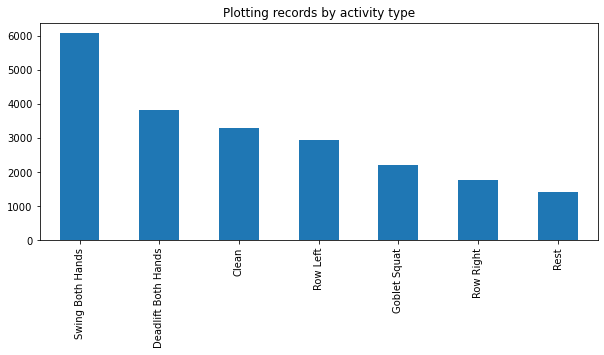

In [29]:
df['Activity'].value_counts().plot(kind='bar', title='Plotting records by activity type', figsize=(10, 4),align='center')

In [43]:
acc_scalar(df)
magnitude(df)
frequency(df)

# Inspect the accelerometer and gyro data
Now it is time to review the actual contents of the sensor data for different excersizes and see if there are any issues with the data.



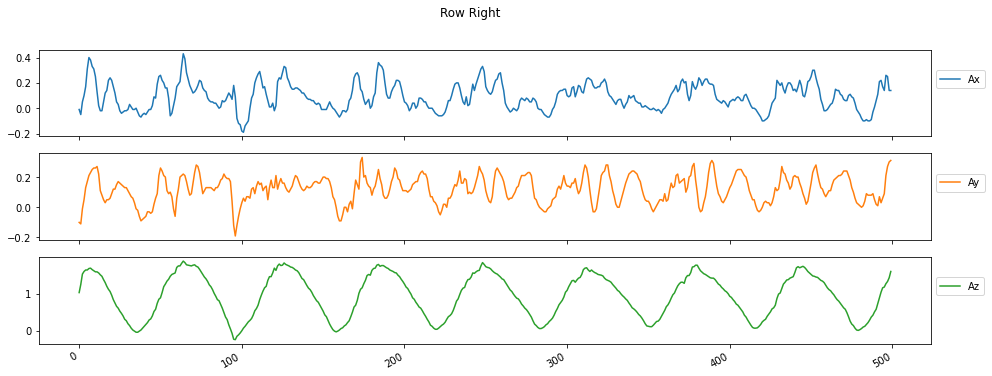

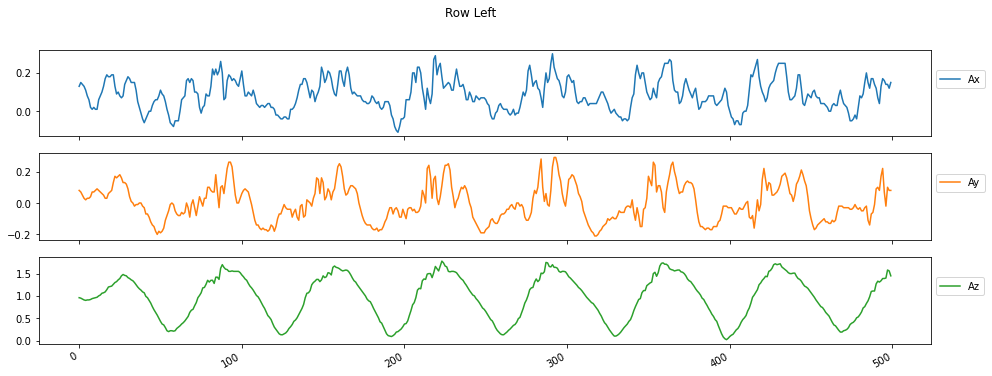

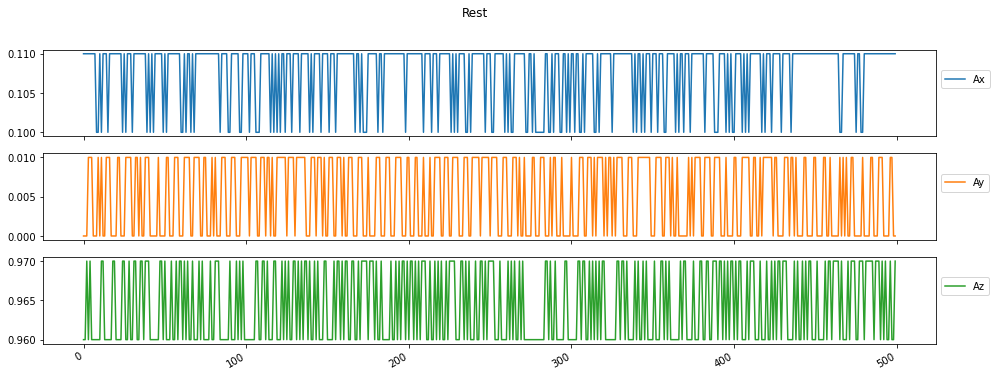

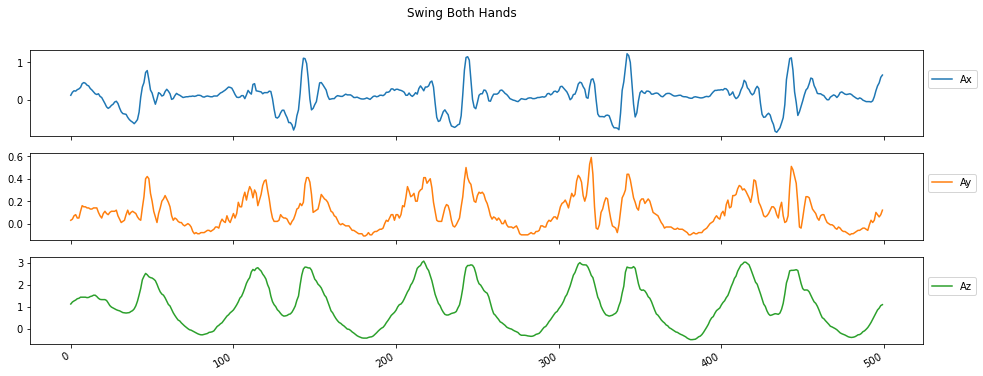

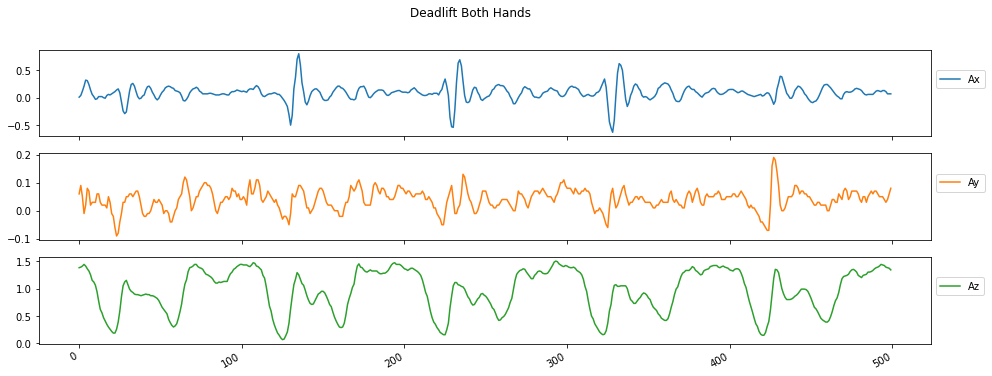

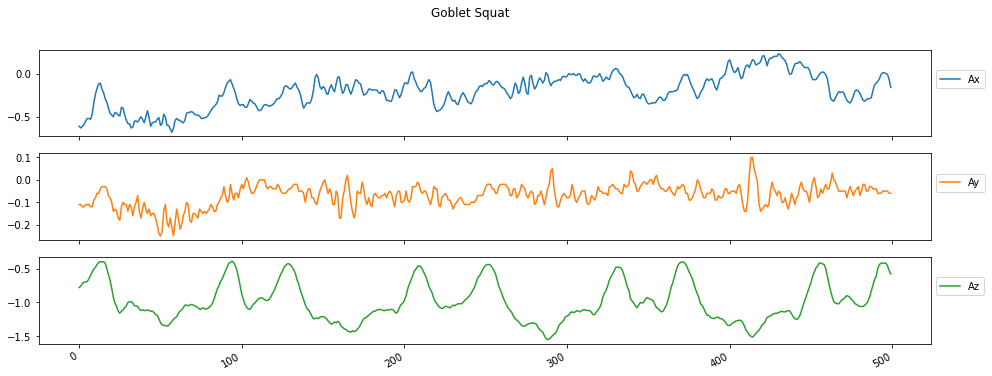

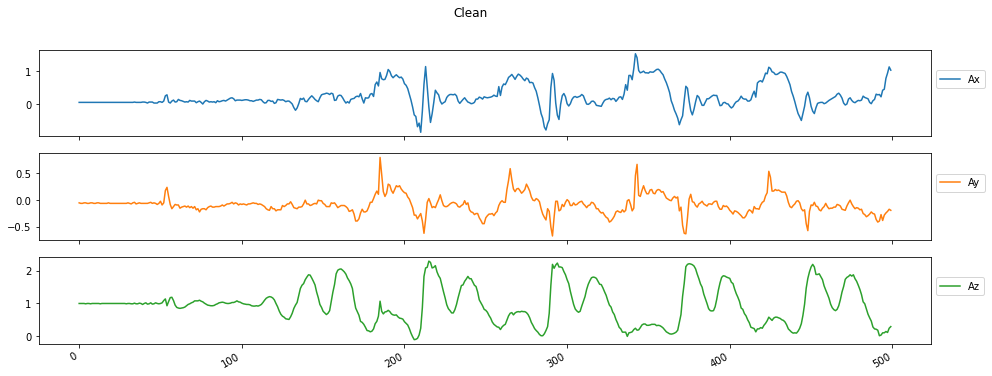

In [44]:
plot_datasets(df,i=500)

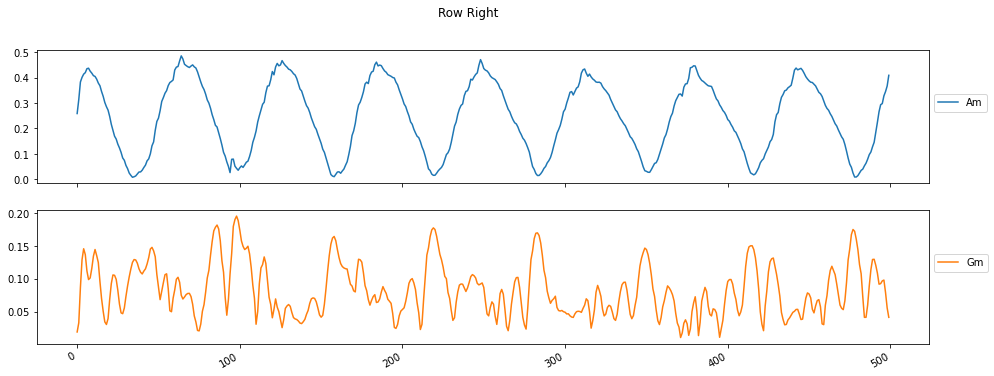

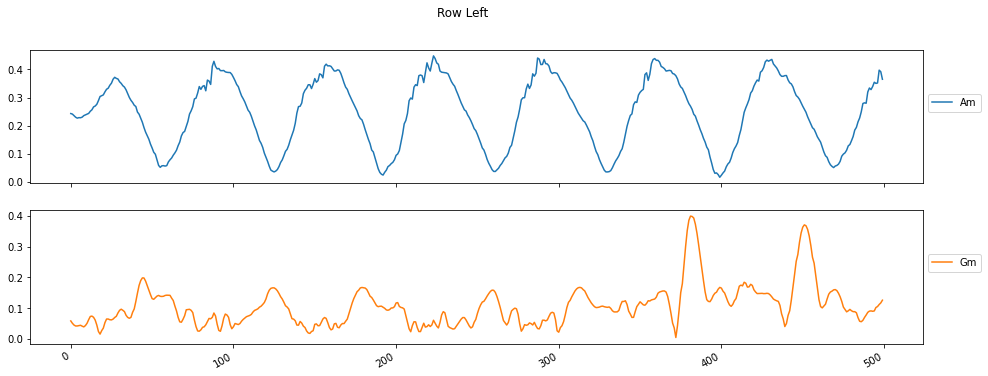

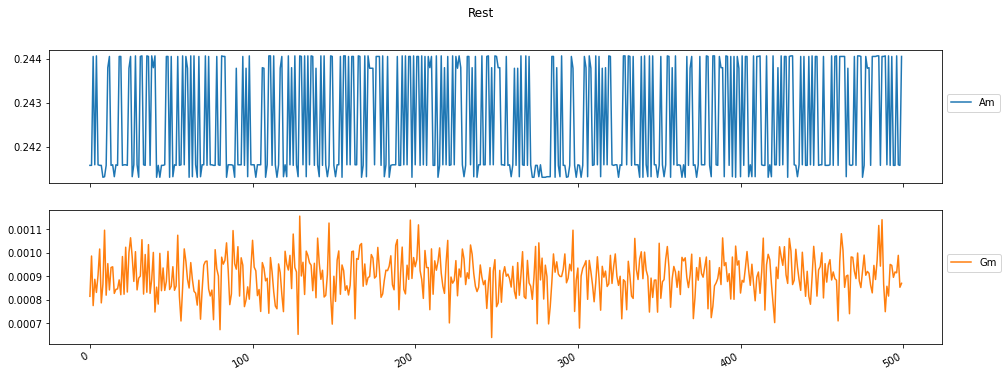

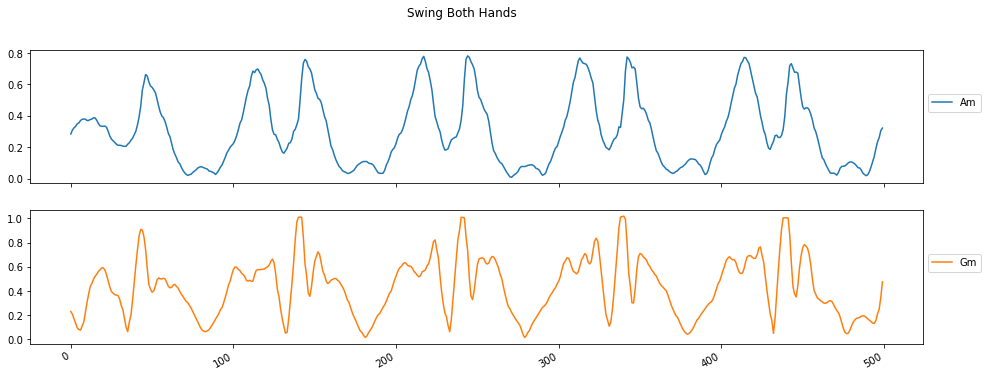

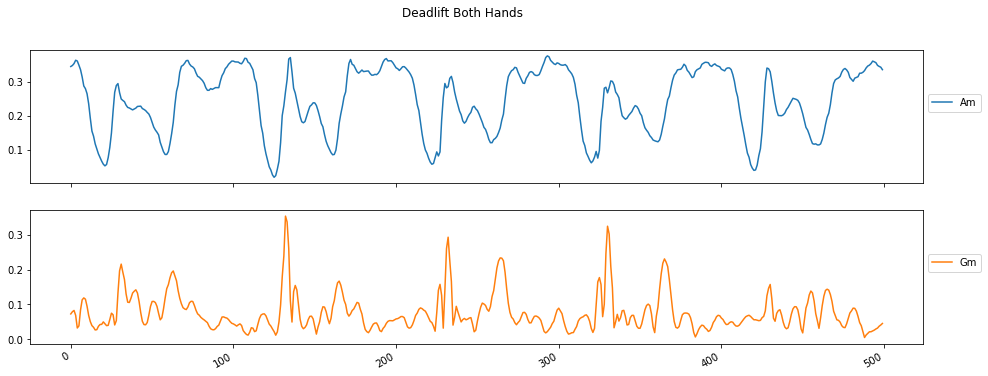

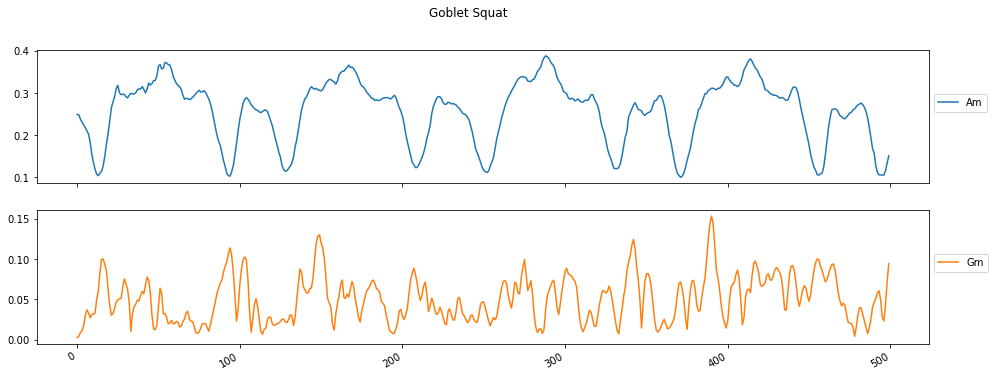

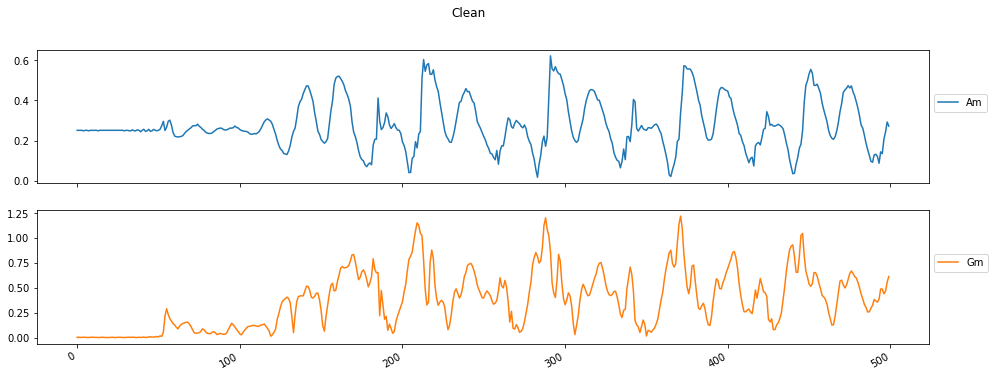

In [50]:
plot_datasets_magnitude(df,i=500)

# Samping frequency 
The frequency is different som some of the sampling data due to the different methods that have been used for data recording

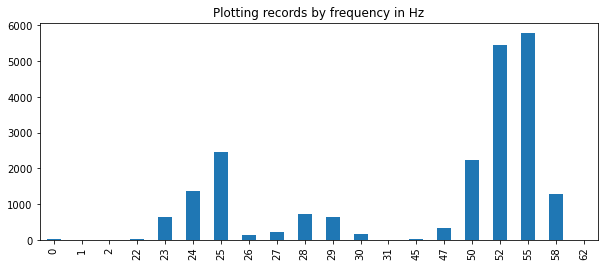

In [41]:
df['Hz'].value_counts().sort_index().plot(kind='bar', title='Plotting records by frequency in Hz', figsize=(10, 4),align='center')